In [1]:
import os
import ast
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
plt.rcParams["font.sans-serif"]=["WenQuanYi Micro Hei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 禁止随机，结果可复现
random.seed(42)
np.random.seed(42)

## 超参数选择

In [39]:
# Parameters
stage_id = 0
data_number = 200

In [46]:
stage = ['计算矩阵', '读取矩阵'][stage_id]
model = 'Deep-learning/Ours'

ROOT_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering'
Clustering_Method = 'DTW_KMeans'
Emotion_Data_PATH = f'{ROOT_PATH}/data/Emotion_Data/{model}'   # 情绪数据路径
Financial_Data_PATH = f'{ROOT_PATH}/data/Financial_Data' # 金融数据路径

print(f"Running with: emo_index={emo_index}, stage={stage}, model={model}, data_number={data_number}")

Running with: emo_index=上证综合情绪值, stage=计算矩阵, model=Deep-learning/Ours, data_number=183


## 数据准备

In [4]:
"""读取股吧个股的数据"""
all_data = []

file_list = [f for f in os.listdir(Emotion_Data_PATH) if f.endswith('.csv')]

for file in tqdm(file_list, desc="读取文件"):
    file_path = os.path.join(Emotion_Data_PATH, file)
    try:
        df = pd.read_csv(file_path, usecols=['日期', '高维情绪变量'])  # 只读需要的列
    except Exception as e:
        print(f"读取失败 {file}: {e}")
        continue

    stock_code = os.path.splitext(file)[0]

    df['股票编号'] = stock_code
    all_data.append(df)

guba_data = pd.concat(all_data, ignore_index=True)

读取文件: 100%|██████████| 183/183 [01:09<00:00,  2.64it/s]


In [5]:
"""读取股票回报率的数据"""
return_data = pd.read_csv(f'{Financial_Data_PATH}/日个股回报率.csv', dtype={'股票编号': str})
return_data

,股票编号,日期,交易量,收益率变化
0,000002,2021-06-01,60990961,-0.003745
1,000002,2021-06-02,85354506,0.006015
2,000002,2021-06-03,50594187,-0.003363
3,000002,2021-06-04,71422364,-0.012748
4,000002,2021-06-07,64745280,-0.014812
...,...,...,...,...
154877,688981,2024-11-20,58507495,-0.017071
154878,688981,2024-11-21,56197106,0.002358
154879,688981,2024-11-22,79240108,-0.050588
154880,688981,2024-11-25,76905909,-0.029402


In [6]:
# 进行左连接，guba_data 为主表
merged_data = pd.merge(guba_data, return_data[['股票编号', '日期', '交易量', '收益率变化']], 
                       on=['股票编号', '日期'], 
                       how='left')
merged_data = merged_data.dropna()
merged_data

,日期,高维情绪变量,股票编号,交易量,收益率变化
1,2024-11-18,"[-0.6446929574012756, 0.14099551737308502, 0.4...",601933,310012824.0,-0.004608
11,2024-11-15,"[0.1293330043554306, 0.09604927152395248, 0.27...",601933,423271473.0,-0.064655
12,2024-11-15,"[-0.2680806517601013, -0.1567424088716507, 0.0...",601933,423271473.0,-0.064655
13,2024-11-14,"[-0.07651520520448685, 0.15938621759414673, 0....",601933,372259052.0,-0.053061
14,2024-11-14,"[0.006571004167199135, 0.11613357812166214, 0....",601933,372259052.0,-0.053061
...,...,...,...,...,...
495148,2021-06-01,"[0.1541367471218109, -0.010554437525570393, 0....",601919,268816321.0,0.045859
495149,2021-06-01,"[-0.19474640488624573, 0.09393686801195145, 0....",601919,268816321.0,0.045859
495150,2021-06-01,"[0.020837007090449333, 0.5046955943107605, 0.4...",601919,268816321.0,0.045859
495151,2021-06-01,"[0.10551305115222931, 0.36309948563575745, 0.2...",601919,268816321.0,0.045859


## 数据预处理

In [10]:
# 对每个股票编号的数据进行标准化和按日期汇总
tqdm.pandas()

def process_data(df):
    df_processed = []

    # 确保高维情绪变量是 list 类型（如果还没转过）
    if isinstance(df['高维情绪变量'].iloc[0], str):
        df['高维情绪变量'] = df['高维情绪变量'].progress_apply(ast.literal_eval)

    # 对每个股票编号处理，加 tqdm 进度条
    for stock_code, stock_data in tqdm(df.groupby('股票编号'), desc="Processing stocks"):
        for date, group in stock_data.groupby('日期'):
            try:
                emotion_matrix = np.array(group['高维情绪变量'].tolist())  # (样本数, 维度)
                avg_emotion = emotion_matrix.mean(axis=0).round(3).tolist()

                summary_row = {
                    '股票编号': stock_code,
                    '日期': date,
                    '高维情绪变量': avg_emotion,
                    '交易量': group['交易量'].mean(),
                    '收益率变化': group['收益率变化'].mean()
                }
                df_processed.append(summary_row)
            except Exception as e:
                print(f"跳过股票{stock_code} 日期{date}：{e}")
                continue

    return pd.DataFrame(df_processed)
    
# 调用处理函数
final_data = process_data(merged_data)
final_data

Processing stocks: 100%|██████████| 183/183 [00:27<00:00,  6.77it/s]


,股票编号,日期,高维情绪变量,交易量,收益率变化
0,000002,2021-06-01,"[-0.178, -0.141, 0.283, 0.184, -0.002, 0.299, ...",60990961.0,-0.003745
1,000002,2021-06-08,"[-0.276, -0.035, 0.247, 0.326, 0.018, 0.244, -...",44676494.0,0.004626
2,000002,2021-06-10,"[-0.083, 0.072, 0.273, 0.26, -0.087, 0.276, -0...",53800776.0,-0.010035
3,000002,2021-06-11,"[-0.114, 0.163, 0.381, 0.325, -0.091, 0.088, -...",75853738.0,-0.014035
4,000002,2021-06-15,"[-0.169, 0.147, 0.442, 0.245, -0.009, 0.368, -...",89915501.0,-0.020957
...,...,...,...,...,...
85724,688981,2024-11-12,"[-0.134, -0.011, 0.308, 0.208, 0.049, 0.263, -...",108866759.0,-0.036864
85725,688981,2024-11-13,"[-0.228, 0.028, 0.358, 0.294, -0.137, 0.178, -...",80759477.0,-0.019484
85726,688981,2024-11-14,"[-0.18, 0.054, 0.392, 0.292, -0.048, 0.215, -0...",76194102.0,-0.022897
85727,688981,2024-11-15,"[-0.159, 0.022, 0.377, 0.319, -0.086, 0.268, -...",71066743.0,-0.020233


## DTW 聚类

In [40]:
# 选择需要的列
dtw_df = final_data[['日期', '股票编号', '高维情绪变量', '收益率变化']]

# 按照股票编号和日期排序
dtw_df = dtw_df.sort_values(by=['股票编号', '日期'])

# 创建一个以股票编号为键，日期为时间序列的字典
stock_data = {}
if data_number > len(dtw_df['股票编号'].unique()):
    data_number = len(dtw_df['股票编号'].unique())
for stock in dtw_df['股票编号'].unique()[:data_number]:
    stock_data[stock] = dtw_df[dtw_df['股票编号'] == stock][['日期', '高维情绪变量', '收益率变化']].reset_index(drop=True)

In [41]:
if stage == '计算矩阵':
    from tqdm import tqdm
    from fastdtw import fastdtw
    from scipy.spatial.distance import euclidean
    
    # 假设stock_data已经准备好了，stock_ids包含所有股票编号
    stock_ids = list(stock_data.keys())
    dtw_distances = np.zeros((len(stock_ids), len(stock_ids)))
    
    # 使用 tqdm 包装外层循环以显示进度条
    for i, stock_i in tqdm(enumerate(stock_ids), total=len(stock_ids), desc="计算 DTW 距离", unit="股票"):
        for j, stock_j in enumerate(stock_ids):
            if i < j:
                # 构造 series_i（二维数组，每行是 [情绪1, ..., 情绪N, 收益率]）
                df_i = stock_data[stock_i]
                series_i = [
                    emotion_vec + [ret]
                    for emotion_vec, ret in zip(df_i['高维情绪变量'], df_i['收益率变化'])
                ]

                df_j = stock_data[stock_j]
                series_j = [
                    emotion_vec + [ret]
                    for emotion_vec, ret in zip(df_j['高维情绪变量'], df_j['收益率变化'])
                ]

                # 使用 fastdtw 计算 DTW 距离
                distance, _ = fastdtw(series_i, series_j, dist=euclidean)
                dtw_distances[i, j] = distance
                dtw_distances[j, i] = distance  # 对称填充

    # 保存结果
    save_dir = f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_高维情绪'
    os.makedirs(save_dir, exist_ok=True)
    np.save(f'{save_dir}/dtw_distances.npy', dtw_distances)
    print(f'DTW距离矩阵已保存至：{save_dir}')

计算 DTW 距离: 100%|██████████| 183/183 [29:43<00:00,  9.75s/股票] 

DTW距离矩阵已保存至：/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/DTW_KMeans/个股分析/183/Deep-learning/Integrated_task/个股分析_高维情绪


In [42]:
# 读取 DTW 距离矩阵
stock_ids = list(stock_data.keys())
dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_高维情绪/dtw_distances.npy')

In [43]:
from sklearn.cluster import KMeans

# KMeans 聚类
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(dtw_distances)

# 查看每个股票的聚类结果
stock_clusters = {stock_ids[i]: clusters[i] for i in range(len(stock_ids))}

# 创建一个 DataFrame 来保存股票编号与对应的聚类标签
stock_clusters_df = pd.DataFrame({
    '股票编号': stock_ids,
    '聚类标签': clusters
})

stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_高维情绪/clusters_results.csv', index=False, encoding='utf-8')
stock_clusters

{'000002': np.int32(2),
 '000061': np.int32(1),
 '000063': np.int32(2),
 '000069': np.int32(1),
 '000100': np.int32(2),
 '000333': np.int32(2),
 '000513': np.int32(1),
 '000625': np.int32(2),
 '000651': np.int32(2),
 '000661': np.int32(2),
 '000681': np.int32(0),
 '000723': np.int32(2),
 '000725': np.int32(2),
 '000858': np.int32(2),
 '000895': np.int32(1),
 '000910': np.int32(1),
 '000937': np.int32(0),
 '000999': np.int32(1),
 '001979': np.int32(0),
 '002008': np.int32(0),
 '002024': np.int32(2),
 '002065': np.int32(0),
 '002142': np.int32(1),
 '002202': np.int32(0),
 '002230': np.int32(2),
 '002241': np.int32(2),
 '002271': np.int32(2),
 '002304': np.int32(2),
 '002368': np.int32(1),
 '002371': np.int32(2),
 '002387': np.int32(1),
 '002415': np.int32(0),
 '002460': np.int32(2),
 '002466': np.int32(2),
 '002475': np.int32(2),
 '002594': np.int32(2),
 '003816': np.int32(1),
 '300002': np.int32(0),
 '300003': np.int32(0),
 '300012': np.int32(1),
 '300014': np.int32(0),
 '300015': np.in

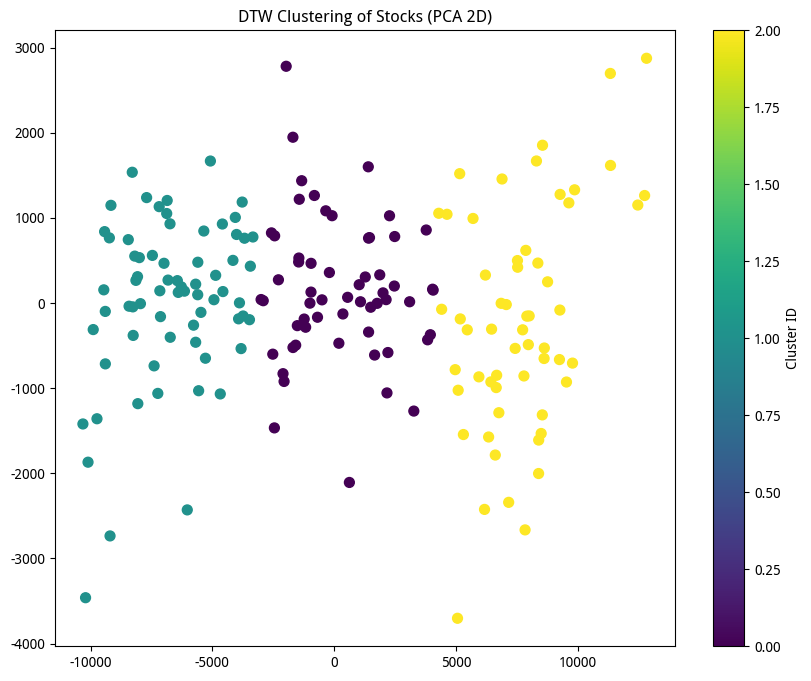

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 使用 PCA 将 DTW 距离矩阵降维为 2D
pca = PCA(n_components=2)
dtw_distances_2d = pca.fit_transform(dtw_distances)

# 创建绘图（2D）
plt.figure(figsize=(10, 8))
scatter = plt.scatter(dtw_distances_2d[:, 0], dtw_distances_2d[:, 1], c=clusters, cmap='viridis', s=50)

# 添加颜色条
plt.colorbar(scatter, label='Cluster ID')

# 设置标题
plt.title('DTW Clustering of Stocks (PCA 2D)')

# 保存路径
save_path = f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_高维情绪/DTW_Clustering_of_Stocks3.png'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()


## 数据集成

In [45]:
# 读取两个CSV文件
cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_高维情绪/clusters_results.csv', dtype={'股票编号': str})
company_info_df = pd.read_csv(f'{Financial_Data_PATH}/中国公司代码.csv', dtype={'Stkcd': str})  

# 重命名列名，统一为 'Stkcd' 以便合并
cluster_df = cluster_df.rename(columns={'股票编号': 'Stkcd'})

# 显式统一合并键的数据类型
cluster_df['Stkcd'] = cluster_df['Stkcd'].astype(str)
company_info_df['Stkcd'] = company_info_df['Stkcd'].astype(str)

# 合并前清除可能重复的列，防止冲突
if 'Stknme' in cluster_df.columns:
    cluster_df = cluster_df.drop(columns=['Stknme'])

# 安全合并
merged_df = pd.merge(cluster_df, company_info_df[['Stkcd', 'Stknme']], on='Stkcd', how='left')
merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_高维情绪/clusters_results.csv', index=False)

merged_df

,Stkcd,聚类标签,Stknme
0,000002,2,万科A
1,000061,1,农产品
2,000063,2,中兴通讯
3,000069,1,华侨城A
4,000100,2,TCL科技
...,...,...,...
178,603986,2,兆易创新
179,688005,1,容百科技
180,688027,1,国盾量子
181,688029,1,南微医学
